## Task intro

Задача - определение оттока абонентов с повышенным потреблением. Характеристика абонентов: b2c, время жизни больше 90 дней, с LTD < 1 (last_trans_date), ARPU за 4 недели >= 500. Оттоком считаем LTD >=7.

Предикторы считались за 3 месяца до выбранной даты, целевая переменная - на месяце после. 

In [1]:
import pandas as pd
import numpy as np
from pyhive import hive
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta, date
from sklearn import metrics
import pickle
import time
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [2]:
!kinit -kt edtolstov.keytab edtolstov
!klist

Ticket cache: FILE:/tmp/krb5cc_815720870
Default principal: edtolstov@BEE.VIMPELCOM.RU

Valid starting       Expires              Service principal
04/01/2019 12:50:06  04/01/2019 22:50:06  krbtgt/BEE.VIMPELCOM.RU@BEE.VIMPELCOM.RU
	renew until 04/08/2019 12:50:06


In [3]:
conn = hive.Connection(host = "hd-has014.vimpelcom.ru", port = "10000", username = "edtolstov", database = "arstel", 
                       auth = "KERBEROS", kerberos_service_name = "hive", configuration = {'job.queue.name': 'adhoc'})
cursor = conn.cursor()

In [4]:
s00='''set mapred.job.queue.name=adhoc'''
cursor.execute(s00)

## Data load

In [51]:
# Определяем временные промежутки

import datetime

today = date.today()

time_start = today - timedelta(days = today.weekday(), weeks = 12)
time_end=time_start+timedelta(days = 28)
time_m1=time_start-timedelta(days = 30)
time_m2=time_start-timedelta(days = 60)
time_m3=time_start-timedelta(days = 90)

time_start1 = ("'P" + str(time_start.year).zfill(4) + str(time_start.month).zfill(2) + 
                 str(time_start.day).zfill(2) + "'")
time_end1 = ("'P" + str(time_end.year).zfill(4) + str(time_end.month).zfill(2) + 
                 str(time_end.day).zfill(2) + "'")
time_m1_1 = ("'P" + str(time_m1.year).zfill(4) + str(time_m1.month).zfill(2) + 
                 str(time_m1.day).zfill(2) + "'")
time_m2_1 = ("'P" + str(time_m2.year).zfill(4) + str(time_m2.month).zfill(2) + 
                 str(time_m2.day).zfill(2) + "'")
time_m3_1 = ("'P" + str(time_m3.year).zfill(4) + str(time_m3.month).zfill(2) + 
                 str(time_m3.day).zfill(2) + "'")

time_min = today - timedelta(days = today.weekday(), weeks = 27)# 15
time_min = ("'P" + str(time_min.year).zfill(4) + str(time_min.month).zfill(2) + 
                 str(time_min.day).zfill(2) + "'")

# -------------------------------------------------
time_start2 = ("'" + str(time_start.year).zfill(4) + '-' + str(time_start.month).zfill(2) + '-' + 
                 str(time_start.day).zfill(2) + "'")

time_end2 = ("'" + str(time_end.year).zfill(4) + '-' + str(time_end.month).zfill(2) + '-' + 
                 str(time_end.day).zfill(2) + "'")

time_m1_2 = ("'" + str(time_m1.year).zfill(4)  + '-' + str(time_m1.month).zfill(2) + '-' + 
                 str(time_m1.day).zfill(2) + "'")

time_m2_2 = ("'" + str(time_m2.year).zfill(4)  + '-' + str(time_m2.month).zfill(2) + '-' + 
                 str(time_m2.day).zfill(2) + "'")

time_m3_2 = ("'" + str(time_m3.year).zfill(4)  + '-' + str(time_m3.month).zfill(2) + '-' + 
                 str(time_m3.day).zfill(2) + "'")


print(time_start1, time_end1, time_m1_1, time_m2_1, time_m3_1, time_min)
print(time_start2,time_end2,time_m1_2,time_m2_2,time_m3_2)

'P20190107' 'P20190204' 'P20181208' 'P20181108' 'P20181009' 'P20180924'
'2019-01-07' '2019-02-04' '2018-12-08' '2018-11-08' '2018-10-09'


In [65]:
s1 = '''
create table arstel.edt_mf_churn_new_feats_full_mnp as
with mnp_t as 
(
select 
case 
when length(ctn) = 11 and substr(ctn, 1, 1) in ('7', '8') 
then substr(ctn, 2, 10) else ctn 
end as ctn, ban, 
min(req_created) as req_created,
max(operator_code) as operator_code
from mnp.requests 
WHERE process_type = 'PortOut'
AND status NOT LIKE 'CNCL%'
AND status NOT LIKE 'DRFT%'

and req_created >= {time_m3_2}
and req_created <  {time_start2}
group by 
case 
when length(ctn) = 11 and substr(ctn, 1, 1) in ('7', '8') 
then substr(ctn, 2, 10) else ctn 
end, ban
)
,t2 as (
select
topten.ctn as subs_key,
case when length(all_topten1) = 11 and substr(all_topten1, 1, 1) in ('7', '8') 
then substr(all_topten1, 2, 10) else all_topten1 
end as all_topten1

from customer360.stg_contacts_top10_monthly topten
LATERAL VIEW explode(all_topten) adTable as all_topten1
where 1=1
and topten.time_key >= {time_m3_2}
and topten.time_key <  {time_start2}
)
,mnp_top10 as (
select

t2.subs_key,

collect_list(case when mnp_t.req_created is null then 0 else 1 end) as mnp_ind_lst, 
collect_list(mnp_t.operator_code) as operator_lst,
collect_list(mnp_t.ctn) as mnp_lst

from t2 
left join mnp_t 
ON t2.all_topten1 = mnp_t.ctn
group by t2.subs_key
)

select pt.time_key,pt.subs_key,pt.ban_key,pt.market_key,
price_plan_key,pp_archetype,
i2,last_balance,p115,p127,p21,p37,p66,t29,t39,t63,p137,
t294,
p118,p119,p123,
k3,v42, 
V63,
M1_ARPU,ALL_M3_ARPU,M1_VOICE_UNIQUE_SUBS,M1_OUTGOING,M3_OUTGOING,M1_INCOMING,M3_INCOMING,M1_INACTIVITY,M3_INACTIVITY
,M1_OUTGOING+M1_INCOMING                          as M1_VOICE_TOTAL
,M3_OUTGOING+M3_INCOMING                          as M3_VOICE_TOTAL
,M1_OUTGOING+M1_INCOMING-M3_OUTGOING-M3_INCOMING  as delta_voice_total
,M1_INACTIVITY-M3_INACTIVITY                      as delta_inactivity
,(M1_ARPU/ALL_M3_ARPU)*3                          as ARPU_RECENCY_3M
,power(((M1_OUTGOING+M1_INCOMING)/(M3_OUTGOING+M3_INCOMING)), 0.333333) as VOICE_TOTAL_CAGR_3M
,m.multi2_prob_top
,d6.age_category

,tar.ltd

,badcl3.tot_data_traf_m as tot_data_traf_m_m3 
,badcl3.tot_voice_traf_m as tot_voice_traf_m_m3 
,badcl3.data_badcell_m as data_badcell_m_m3 
,badcl3.voice_badcell_m as voice_badcell_m_m3 
,badcl3.data_badcell_share as data_badcell_share_m3 
,badcl3.voice_badcell_share as voice_badcell_share_m3 
,badcl3.bad_data_ind_str as bad_data_ind_str_m3 
,badcl3.bad_voice_ind_str as bad_voice_ind_str_m3 
,badcl3.bad_data_ind_low as bad_data_ind_low_m3 
,badcl3.bad_voice_ind_low as bad_voice_ind_low_m3

,badcl2.tot_data_traf_m as tot_data_traf_m_m2 
,badcl2.tot_voice_traf_m as tot_voice_traf_m_m2 
,badcl2.data_badcell_m as data_badcell_m_m2 
,badcl2.voice_badcell_m as voice_badcell_m_m2 
,badcl2.data_badcell_share as data_badcell_share_m2 
,badcl2.voice_badcell_share as voice_badcell_share_m2 
,badcl2.bad_data_ind_str as bad_data_ind_str_m2 
,badcl2.bad_voice_ind_str as bad_voice_ind_str_m2 
,badcl2.bad_data_ind_low as bad_data_ind_low_m2 
,badcl2.bad_voice_ind_low as bad_voice_ind_low_m2 

,badcl1.tot_data_traf_m as tot_data_traf_m_m1 
,badcl1.tot_voice_traf_m as tot_voice_traf_m_m1 
,badcl1.data_badcell_m as data_badcell_m_m1 
,badcl1.voice_badcell_m as voice_badcell_m_m1 
,badcl1.data_badcell_share as data_badcell_share_m1 
,badcl1.voice_badcell_share as voice_badcell_share_m1 
,badcl1.bad_data_ind_str as bad_data_ind_str_m1 
,badcl1.bad_voice_ind_str as bad_voice_ind_str_m1 
,badcl1.bad_data_ind_low as bad_data_ind_low_m1 
,badcl1.bad_voice_ind_low as bad_voice_ind_low_m1


,device1.distinct_tac


,mnp_t.req_created
,mnp_t.operator_code

,mnp_top10.mnp_ind_lst
,mnp_top10.operator_lst
,mnp_top10.mnp_lst

,case when tar.ltd <7 then 0 else 1 end as target

from

(select 
 time_key,subs_key,ban_key,market_key , P66 as LTD2_CURR, 
 price_plan_key,pp_archetype,
 i2,last_balance,p115,p127,p21,p37,p66,t29,t39,t63,p137
 from datamart.agg_pm_kpi_weekly_prp_pt p
         left join biis.dim_price_plan n
         on p.i1 = n.price_plan_key 
    where time_key= {time_start1} and i2>=90 and P66 >= 0  and P66 <= 1 and p36>=500  and 
          n.pp_archetype in ('B2C Bundle', 'B2C Bundle Unlim','B2C LowBundle', 
                              'B2C VAS', 'B2C archive', 'B2C flat','B2C onnet',   
                    'B2C other', 'CIS','SEBDONOR','B2C Bundle Conv','SEBDONOR Conv')) pt

left join     
  (select
    time_key,subs_key,ban_key,market_key,t294
    from datamart.agg_pm_kpi_weekly_prp_pt_2
    where time_key= {time_start1}) pt_2
on      pt.subs_key=pt_2.subs_key and pt.ban_key=pt_2.ban_key and pt.market_key=pt_2.market_key

left join
  (select
    time_key,subs_key,ban_key,market_key,p118,p119,p123
    from datamart.agg_pm_kpi_weekly_prp_pt_3
    where time_key={time_start1}  ) pt_3
 on    pt.subs_key=pt_3.subs_key and pt.ban_key=pt_3.ban_key and pt.market_key=pt_3.market_key 

left join     
  (select
    time_key,subs_key,ban_key,market_key,k3,v42
    from datamart.agg_pm_kpi_weekly_prp_iksvc
    where time_key={time_start1}  ) iksvc
on      pt.subs_key=iksvc.subs_key and pt.ban_key=iksvc.ban_key and pt.market_key=iksvc.market_key  

left join 
(select
    time_key,subs_key,ban_key,market_key,V63
    from datamart.agg_pm_kpi_weekly_prp_iksvc_4
    where time_key={time_start1} ) iksvc_4
on      pt.subs_key=iksvc_4.subs_key and pt.ban_key=iksvc_4.ban_key and pt.market_key=iksvc_4.market_key

left join
(select 
 subs_key,ban_key,market_key,
 sum(case when time_key >= {time_m1_1} and time_key <={time_start1}    then P22 else 0 end) as M1_ARPU,
 sum(case when time_key >= {time_m3_1} and time_key <={time_start1}    then P22 else 0 end) as ALL_M3_ARPU,
 sum(case when time_key >= {time_m1_1} and time_key <={time_start1}    then T124 else 0 end) as M1_VOICE_UNIQUE_SUBS,
 sum(case when time_key >= {time_m1_1} and time_key <={time_start1}    then T48 else 0 end) as M1_OUTGOING,
 sum(case when time_key >= {time_m3_1} and time_key <={time_m2_1}       then T48 else 0 end) as M3_OUTGOING,
 sum(case when time_key >= {time_m1_1} and time_key <={time_start1}    then T59 else 0 end) as M1_INCOMING,
 sum(case when time_key >= {time_m3_1} and time_key <={time_m2_1}       then T59 else 0 end) as M3_INCOMING,
 sum(case when time_key >= {time_m1_1} and time_key <={time_start1}   
     then (case when P66 <= 7 then p66 else 7 end) else 0 end) as M1_INACTIVITY,
 sum(case when time_key >= {time_m3_1} and time_key <= {time_m2_1}
     then (case when P66 <= 7 then p66 else 7 end) else 0 end) as M3_INACTIVITY

from  datamart.AGG_PM_KPI_WEEKLY_PRP_PT  where(TIME_KEY >= {time_min} and TIME_KEY <= {time_start1})
group by subs_key,ban_key,market_key ) d4
 on    pt.subs_key=d4.subs_key and pt.ban_key=d4.ban_key and pt.market_key=d4.market_key

left join 
(select subs_key,ban_key,market_key, avg(multi2_prob_top) as multi2_prob_top
from  cvm.scoring_multisim_2_5_history
 where multi2_prob is not null
and date_key >={time_m1_2}
    and date_key < {time_start2}
     group by subs_key,ban_key,market_key
 ) m
on pt.subs_key=m.subs_key and pt.ban_key=m.ban_key and pt.market_key=m.market_key

left join
(
select subs_key, ban_key,market_key, max(age_category) as age_category
from SPP.AGG_MODEL_AGE_MONTHLY
where time_key >={time_m3_2}
and time_key <= {time_start2}
group by subs_key, ban_key,market_key
) d6

on pt.subs_key=d6.subs_key and pt.ban_key=d6.ban_key and pt.market_key=d6.market_key

left join
(select SUBS_KEY, BAN_KEY, MARKET_KEY, P66 AS LTD
FROM datamart.AGG_PM_KPI_WEEKLY_PRP_PT 
where TIME_KEY = {time_end1}  ) tar
on pt.subs_key=tar.subs_key and pt.ban_key=tar.ban_key and pt.market_key=tar.market_key

left join
(
select 
ctn, ban_key,
avg(tot_data_traf_m) as tot_data_traf_m, 
avg(tot_voice_traf_m) as tot_voice_traf_m,

avg(data_badcell_m) as data_badcell_m, 
avg(voice_badcell_m) as voice_badcell_m, 

avg(data_badcell_share) as data_badcell_share, 
avg(voice_badcell_share) as voice_badcell_share, 

avg(bad_data_ind_str) as bad_data_ind_str, 
avg(bad_voice_ind_str) as bad_voice_ind_str, 
avg(bad_data_ind_low) as bad_data_ind_low, 
avg(bad_voice_ind_low) as bad_voice_ind_low 

from customer360.stg_badcell_weekly
where 1=1
and time_key >={time_m3_2}
and time_key < {time_m2_2}

group by ctn, ban_key
) badcl3
on pt.subs_key = badcl3.ctn and pt.ban_key=badcl3.ban_key

left join
(
select 
ctn, ban_key,
avg(tot_data_traf_m) as tot_data_traf_m, 
avg(tot_voice_traf_m) as tot_voice_traf_m,

avg(data_badcell_m) as data_badcell_m, 
avg(voice_badcell_m) as voice_badcell_m, 

avg(data_badcell_share) as data_badcell_share, 
avg(voice_badcell_share) as voice_badcell_share, 

avg(bad_data_ind_str) as bad_data_ind_str, 
avg(bad_voice_ind_str) as bad_voice_ind_str, 
avg(bad_data_ind_low) as bad_data_ind_low, 
avg(bad_voice_ind_low) as bad_voice_ind_low 

from customer360.stg_badcell_weekly
where 1=1
and time_key >={time_m2_2}
and time_key < {time_m1_2}

group by ctn, ban_key
) badcl2
on pt.subs_key = badcl2.ctn and pt.ban_key=badcl2.ban_key

left join
(
select 
ctn, ban_key,
avg(tot_data_traf_m) as tot_data_traf_m, 
avg(tot_voice_traf_m) as tot_voice_traf_m,

avg(data_badcell_m) as data_badcell_m, 
avg(voice_badcell_m) as voice_badcell_m, 

avg(data_badcell_share) as data_badcell_share, 
avg(voice_badcell_share) as voice_badcell_share, 

avg(bad_data_ind_str) as bad_data_ind_str, 
avg(bad_voice_ind_str) as bad_voice_ind_str, 
avg(bad_data_ind_low) as bad_data_ind_low, 
avg(bad_voice_ind_low) as bad_voice_ind_low 

from customer360.stg_badcell_weekly
where 1=1
and time_key >={time_m1_2}
and time_key < {time_start2}

group by ctn, ban_key
) badcl1
on pt.subs_key = badcl1.ctn and pt.ban_key=badcl1.ban_key

left join
(select CTN, count (distinct tac) as distinct_tac
FROM customer360.stg_device_changed
where 1=1
and time_key >={time_m3_2}
and time_key < {time_start2}

group by CTN 
) device1
on pt.subs_key=device1.ctn

left join mnp_t
on pt.subs_key = mnp_t.ctn and pt.ban_key=mnp_t.ban

left join mnp_top10
on pt.subs_key = mnp_top10.subs_key 

'''.format(time_start1 = time_start1,
time_end1 = time_end1,
time_m1_1 = time_m1_1,
time_m2_1 = time_m2_1,
time_m3_1 = time_m3_1,
time_min = time_min,
time_start2 = time_start2,
time_end2 = time_end2,
time_m1_2 = time_m1_2,
time_m2_2 = time_m2_2,
time_m3_2 = time_m3_2)

s1 = s1.replace('\n',' ')

In [66]:
%%time
cursor.execute(s1)

CPU times: user 22.4 ms, sys: 11.4 ms, total: 33.8 ms
Wall time: 55min 20s


### Making sample


In [68]:
%%time

s2 = '''
create table arstel.edt_mf_churn_new_feats_full_mnp_samp as
select 
a.*
from arstel.edt_mf_churn_new_feats_full_mnp a
distribute by rand()
sort by rand()
limit 500000 
'''
cursor.execute(s2)

CPU times: user 4.52 ms, sys: 2.04 ms, total: 6.56 ms
Wall time: 8min 15s


In [5]:
%%time

s1 = "select * from arstel.edt_mf_churn_new_feats_full_mnp_samp"

s1 = s1.replace('\n',' ')

telcom = pd.read_sql(s1, conn)

CPU times: user 2min 8s, sys: 2.57 s, total: 2min 11s
Wall time: 2min 34s


### Preparing data

In [6]:
telcom.columns=['time_key',
'subs_key',
'ban_key',
'market_key',
'price_plan_key',
'pp_archetype',
'i2',
'last_balance',
'p115',
'p127',
'p21',
'p37',
'p66',
't29',
't39',
't63',
'p137',
't294',
'p118',
'p119',
'p123',
'k3',
'v42',
'v63',
'm1_arpu',
'all_m3_arpu',
'm1_voice_unique_subs',
'm1_outgoing',
'm3_outgoing',
'm1_incoming',
'm3_incoming',
'm1_inactivity',
'm3_inactivity',
'm1_voice_total',
'm3_voice_total',
'delta_voice_total',
'delta_inactivity',
'arpu_recency_3m',
'voice_total_cagr_3m',
'multi2_prob_top',
'age_category',
'ltd',
'tot_data_traf_m_m3',
'tot_voice_traf_m_m3',
'data_badcell_m_m3',
'voice_badcell_m_m3',
'data_badcell_share_m3',
'voice_badcell_share_m3',
'bad_data_ind_str_m3',
'bad_voice_ind_str_m3',
'bad_data_ind_low_m3',
'bad_voice_ind_low_m3',
'tot_data_traf_m_m2',
'tot_voice_traf_m_m2',
'data_badcell_m_m2',
'voice_badcell_m_m2',
'data_badcell_share_m2',
'voice_badcell_share_m2',
'bad_data_ind_str_m2',
'bad_voice_ind_str_m2',
'bad_data_ind_low_m2',
'bad_voice_ind_low_m2',
'tot_data_traf_m_m1',
'tot_voice_traf_m_m1',
'data_badcell_m_m1',
'voice_badcell_m_m1',
'data_badcell_share_m1',
'voice_badcell_share_m1',
'bad_data_ind_str_m1',
'bad_voice_ind_str_m1',
'bad_data_ind_low_m1',
'bad_voice_ind_low_m1',
'distinct_tac',

'req_created',
'operator_code',
'mnp_ind_lst',
'operator_lst',
'mnp_lst',
'target']

## Data prep & feature engineering

In [ ]:
#1. badcell prep

In [8]:
telcom['data_badcell_m_m3']=telcom['data_badcell_m_m3']/1000000
telcom['data_badcell_m_m2']=telcom['data_badcell_m_m2']/1000000
telcom['data_badcell_m_m1']=telcom['data_badcell_m_m1']/1000000

telcom['tot_data_traf_m_m1']=telcom['tot_data_traf_m_m1']/1000000
telcom['tot_data_traf_m_m2']=telcom['tot_data_traf_m_m2']/1000000
telcom['tot_data_traf_m_m3']=telcom['tot_data_traf_m_m3']/1000000

In [9]:
#агрегируем по 3 месяцам 

telcom["data_badcell_all"] = (telcom['data_badcell_m_m3'] + telcom['data_badcell_m_m2'] + telcom['data_badcell_m_m1'])/3
telcom["voice_badcell_all"] = (telcom['voice_badcell_m_m3'] + telcom['voice_badcell_m_m2'] + telcom['voice_badcell_m_m1'])/3

telcom["data_badcell_min"] = telcom.loc[:, ['data_badcell_m_m3', 'data_badcell_m_m2', 'data_badcell_m_m1']].min(axis=1)
telcom["data_badcell_max"] = telcom.loc[:, ['data_badcell_m_m3', 'data_badcell_m_m2', 'data_badcell_m_m1']].max(axis=1)

telcom["voice_badcell_min"] = telcom.loc[:, ['voice_badcell_m_m3', 'voice_badcell_m_m2', 'voice_badcell_m_m1']].min(axis=1)
telcom["voice_badcell_max"] = telcom.loc[:, ['voice_badcell_m_m3', 'voice_badcell_m_m2', 'voice_badcell_m_m1']].max(axis=1)

#trends
telcom['data_badcell_chng'] = (telcom['data_badcell_m_m3']/telcom['data_badcell_m_m2'] + telcom['data_badcell_m_m2']/telcom['data_badcell_m_m1'])/2
telcom['voice_badcell_chng'] = (telcom['voice_badcell_m_m3']/telcom['voice_badcell_m_m2'] + telcom['voice_badcell_m_m2']/telcom['voice_badcell_m_m1'])/2

telcom['data_badcell_trend'] = ((telcom['data_badcell_m_m3']/telcom['data_badcell_m_m2'] + telcom['data_badcell_m_m2']/telcom['data_badcell_m_m1'])/2)-1
telcom['voice_badcell_trend'] = ((telcom['voice_badcell_m_m3']/telcom['voice_badcell_m_m2'] + telcom['voice_badcell_m_m2']/telcom['voice_badcell_m_m1'])/2)-1

In [10]:
#2. device 

In [11]:
telcom['tac_changed_flg'] = np.where(telcom['distinct_tac']>1, 1, 0)

In [12]:
#3. MNP

In [13]:
telcom['row_length'] = telcom['mnp_lst'].str.len()

def flag_df(df):
    
    if (df['row_length'] <=2):
        return 0
    elif (df['row_length'] > 2) and (df['row_length'] <=27):
        return 1
    elif (df['row_length'] > 27):
        return 2

telcom['mnp_cnt'] = telcom.apply(flag_df, axis = 1)

In [14]:
telcom['mnp_top10_flg'] = np.where(telcom['mnp_cnt']> 0, 1, 0)

In [16]:
#self mnp 
telcom['mnp_self_flg'] = np.where(telcom['req_created'].notnull(),1,0)

## Model fit

#new feats

1. mnp_top10_flg
2. mnp_cnt
3. operator_lst (categorical)

4. mnp_self_flg

In [17]:
feat = [
'market_key',
'age_category',
'price_plan_key',
'pp_archetype',
'p137',
'operator_lst',

'm1_voice_total',
'm3_voice_total',
'delta_voice_total',
'delta_inactivity',
'arpu_recency_3m',
'voice_total_cagr_3m',
'm1_arpu',
'all_m3_arpu',
'm1_voice_unique_subs',
'm1_outgoing',
'm3_outgoing',
'm1_incoming',
'm3_incoming',
'm1_inactivity',
'm3_inactivity',
'i2',
'last_balance',
'p115',
'p127',
'p21',
'p37',
'p66',
't29',
't39',
't63',
't294',
'p118',
'p119',
'p123', 
'multi2_prob_top'

,'tot_data_traf_m_m1'
,'data_badcell_m_m1'
,'data_badcell_share_m1'    
,'voice_badcell_m_m2'
,'voice_badcell_m_m1'
,'voice_badcell_share_m1'
,"data_badcell_all"
,"voice_badcell_all"
,"data_badcell_min"
,"data_badcell_max"
,"voice_badcell_min"
,"voice_badcell_max"
,'data_badcell_chng'
,'voice_badcell_chng'
,'data_badcell_trend'
,'voice_badcell_trend'

,'distinct_tac'
,'tac_changed_flg'
    
,'mnp_top10_flg'
,'mnp_cnt'
,'mnp_self_flg'
]

In [ ]:
#find NA

In [18]:
X = telcom[feat]
X['age_category'] = X['age_category'].fillna(0)
X['operator_lst'] = X['operator_lst'].fillna(0)
X['mnp_cnt'] = X['mnp_cnt'].fillna(0)

Y = telcom['target']

x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(X, Y, test_size = 0.3)
cat_features=[0,1,2,3,4,5]

In [20]:
# target balance

y=Y

print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))
print('Diff = {}'.format(sum(y)/(len(y) - sum(y))))

Labels: {0, 1}
Zero count = 490375, One count = 9625
Diff = 0.01962783583991843


In [21]:
%%time
model = ( CatBoostClassifier(iterations = 250, depth = 5, learning_rate = 0.03, rsm = 0.9, 
                       loss_function = 'Logloss', 
                       custom_loss = ['AUC', 'Recall', 'Precision'], random_seed = 7 ))

model.fit(x_train_all, y_train_all,cat_features,plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6318970	total: 169ms	remaining: 42.1s
1:	learn: 0.5763880	total: 282ms	remaining: 34.9s
2:	learn: 0.5275041	total: 405ms	remaining: 33.4s
3:	learn: 0.4837620	total: 511ms	remaining: 31.4s
4:	learn: 0.4445185	total: 623ms	remaining: 30.5s
5:	learn: 0.4085120	total: 730ms	remaining: 29.7s
6:	learn: 0.3770968	total: 826ms	remaining: 28.7s
7:	learn: 0.3494983	total: 940ms	remaining: 28.4s
8:	learn: 0.3239084	total: 1.05s	remaining: 28.1s
9:	learn: 0.3002615	total: 1.16s	remaining: 27.9s
10:	learn: 0.2803514	total: 1.27s	remaining: 27.6s
11:	learn: 0.2622222	total: 1.38s	remaining: 27.4s
12:	learn: 0.2454371	total: 1.5s	remaining: 27.3s
13:	learn: 0.2313762	total: 1.6s	remaining: 26.9s
14:	learn: 0.2178222	total: 1.71s	remaining: 26.8s
15:	learn: 0.2057131	total: 1.8s	remaining: 26.4s
16:	learn: 0.1948916	total: 1.91s	remaining: 26.2s
17:	learn: 0.1847187	total: 2.02s	remaining: 26s
18:	learn: 0.1759411	total: 2.13s	remaining: 25.9s
19:	learn: 0.1677060	total: 2.24s	remaining: 2

161:	learn: 0.0770380	total: 17.8s	remaining: 9.66s
162:	learn: 0.0770201	total: 17.9s	remaining: 9.55s
163:	learn: 0.0770136	total: 18s	remaining: 9.45s
164:	learn: 0.0770001	total: 18.1s	remaining: 9.33s
165:	learn: 0.0769861	total: 18.2s	remaining: 9.22s
166:	learn: 0.0769704	total: 18.3s	remaining: 9.12s
167:	learn: 0.0769594	total: 18.5s	remaining: 9.01s
168:	learn: 0.0769483	total: 18.6s	remaining: 8.89s
169:	learn: 0.0769446	total: 18.7s	remaining: 8.79s
170:	learn: 0.0769344	total: 18.8s	remaining: 8.68s
171:	learn: 0.0769272	total: 18.9s	remaining: 8.56s
172:	learn: 0.0769067	total: 19s	remaining: 8.46s
173:	learn: 0.0768956	total: 19.1s	remaining: 8.34s
174:	learn: 0.0768884	total: 19.2s	remaining: 8.23s
175:	learn: 0.0768726	total: 19.3s	remaining: 8.12s
176:	learn: 0.0768573	total: 19.4s	remaining: 8.01s
177:	learn: 0.0768452	total: 19.5s	remaining: 7.9s
178:	learn: 0.0768382	total: 19.6s	remaining: 7.79s
179:	learn: 0.0768312	total: 19.7s	remaining: 7.68s
180:	learn: 0.076

## Reports and cross-val

In [22]:
print(metrics.roc_auc_score(y_test_all, model.predict_proba(x_test_all)[:,1]),
      metrics.precision_score(y_test_all, model.predict(x_test_all)),
      metrics.recall_score(y_test_all, model.predict(x_test_all)))

0.82755033529 0.685714285714 0.0163098878695


In [53]:
x_train_all['arpu_segment_train']=1
x_test_all['arpu_segment_test']=1

arpu_segment_train = x_train_all['arpu_segment_train']
arpu_segment_test = x_test_all['arpu_segment_test']

x_train_all.columns.drop(['arpu_segment_train'])
x_test_all.columns.drop(['arpu_segment_test'])

from MF_Helpers import *

y_pred_train = model.predict(x_train_all)
y_pred_test = model.predict(x_test_all)

y_score_train = model.predict_proba(x_train_all)[:,1]
y_score_test = model.predict_proba(x_test_all)[:,1]

reports_with_thresholds(y_train_all, x_train_all, y_test_all, x_test_all, arpu_segment_train, arpu_segment_test, model)[1][['segment_ARPU', 'top', 'precision_train', 'recall_train', 'precision_test',
                                       'recall_test', 'threshold_train', 'threshold_test']]

segment_ARPU  top  precision_train  recall_train  precision_test  \
0    Extra Low   10         0.105971      0.555073        0.113400   
1    Extra Low   20         0.066314      0.694702        0.070400   
2    Extra Low   30         0.049143      0.772224        0.051622   
3    Extra Low   40         0.039636      0.830440        0.041067   

   recall_test  threshold_train  threshold_test  
0     0.577982         0.036741        0.036734  
1     0.717635         0.018987        0.018922  
2     0.789331         0.013007        0.012947  
3     0.837241         0.010304        0.010285

In [23]:
from catboost import cv
from catboost import *

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 250
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.03

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False #не выводилась информация
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [24]:
cv_data['test-AUC-mean'].mean()

0.8109426485063445

## Feats analysis

In [25]:
pd.DataFrame(model.get_feature_importance(prettified=True)).head(20)

0          1
0                      i2  20.050620
1            last_balance  12.570343
2                    p115   7.658856
3           m3_inactivity   7.160458
4                     p66   5.818462
5           m1_inactivity   5.668812
6                     p21   5.175809
7                     t39   3.966753
8         multi2_prob_top   3.672666
9   data_badcell_share_m1   3.154185
10                   p118   2.652944
11                   p127   2.213644
12       delta_inactivity   1.616898
13                    t29   1.480453
14            m1_incoming   1.335722
15           distinct_tac   1.309313
16                   t294   1.205688
17        arpu_recency_3m   1.184191
18                   p119   1.171238
19    voice_total_cagr_3m   1.073583

### Shap analysis

In [26]:
from catboost import Pool
pool1 = Pool(data=X, label=y, cat_features=cat_features)

In [27]:
shap_values = model.get_feature_importance(pool1, fstr_type='ShapValues')
print(shap_values.shape)

The model has complex ctrs, so the SHAP values will be calculated approximately.


(500000, 58)


In [28]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X, y, cat_features=cat_features))

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/opt/anaconda3/envs/catboost_0_11_1/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
The model has complex ctrs, so the SHAP values will be calculated approximately.


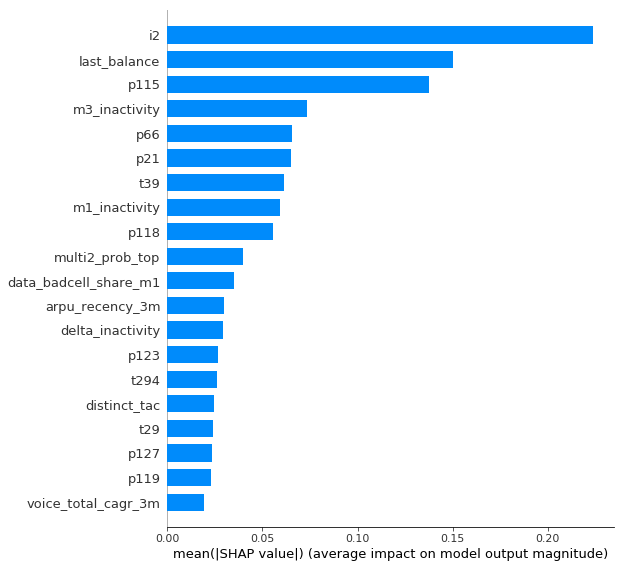

In [29]:
shap.summary_plot(shap_values, X, plot_type="bar")

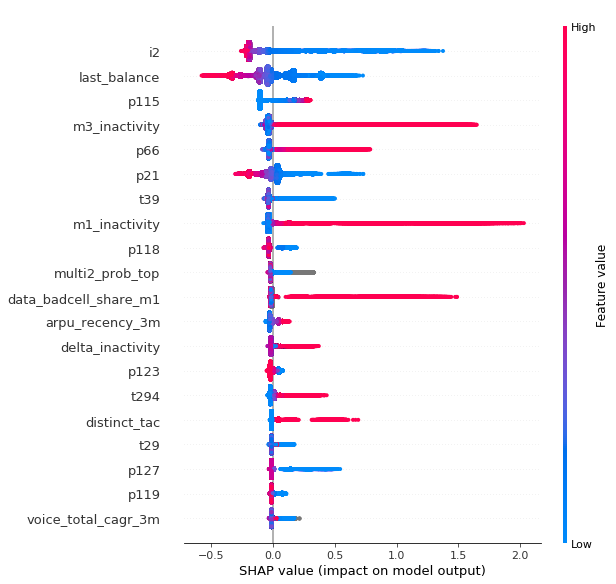

In [30]:
shap.summary_plot(shap_values, X)

In [31]:
X["market_key"] = X["market_key"].astype('category').cat.codes
X["pp_archetype"] = X["pp_archetype"].astype('category').cat.codes
X["p137"] = X["p137"].astype('category').cat.codes
X["age_category"] = X["age_category"].astype('category').cat.codes
X["price_plan_key"] = X["price_plan_key"].astype('category').cat.codes
X["operator_lst"] = X["operator_lst"].astype('category').cat.codes

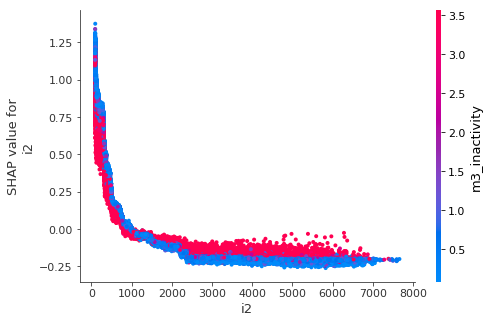

In [32]:
shap.dependence_plot('i2', shap_values, X)

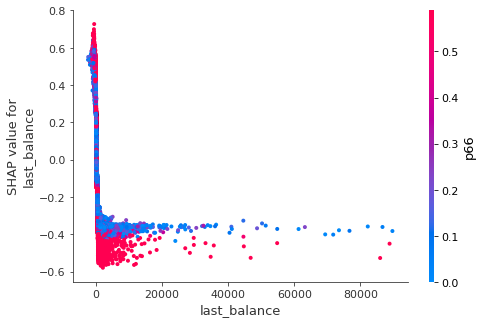

In [34]:
shap.dependence_plot('last_balance', shap_values, X)

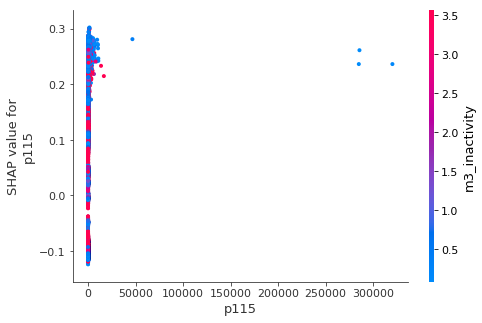

In [54]:
shap.dependence_plot('p115', shap_values, X)

In [35]:
#HIGH churn prob 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[497762,:], X.iloc[497762,:])

In [45]:
#HIGH churn prob 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[499970,:], X.iloc[499970,:])

In [50]:

print(model.predict_proba(X)[497762])
print(model.predict_proba(X)[499970])

[ 0.99446294  0.00553706]
[ 0.76263099  0.23736901]
